In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

In [14]:
train_set=r'/kaggle/input/save2t/WLI/train'
val_set=r'/kaggle/input/save2t/WLI/val'
test_set=r'/kaggle/input/save2t/WLI/test'

In [15]:
train_datagen = image.ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen = image.ImageDataGenerator()
test_datagen = image.ImageDataGenerator()

In [16]:
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    val_set,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 4133 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.
Found 790 images belonging to 6 classes.


In [17]:
train_generator.class_indices

{'dyed-lifted-polyps': 0,
 'dyed-resection-margins': 1,
 'esophagitis': 2,
 'normal-cecum': 3,
 'normal-pylorus': 4,
 'normal-z-line': 5,
 'polyps': 6,
 'ulcerative-colitis': 7}

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet101


class CustomGaussianNoise(tf.keras.layers.GaussianNoise):
    def __init__(self, stddev, **kwargs):
        super(CustomGaussianNoise, self).__init__(stddev, **kwargs)

    def get_config(self):
        config = super().get_config()
        config.update({"stddev": self.stddev})
        return config


base_model = ResNet101(weights='imagenet', input_shape=(224, 224, 3), include_top=False)


for layer in base_model.layers:
    layer.trainable = False


model = Sequential()
model.add(base_model)
model.add(CustomGaussianNoise(0.35))
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(CustomGaussianNoise(0.35))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)               │ (None, 7, 7, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_gaussian_noise_2              │ (None, 7, 7, 2048)          │               0 │
│ (CustomGaussianNoise)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_gaussian_noise_3              │ (None, 256)                 │               0 │
│ (CustomGaussianNoise)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,185,800 (164.74 MB)

 Trainable params: 527,112 (2.01 MB)

 Non-trainable params: 42,658,688 (162.73 MB)

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True)
checkpoint = ModelCheckpoint('bestx_model.keras', monitor='val_loss', save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=75, min_lr=0.00001)


In [21]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=300,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 136s 842ms/step - AUC: 0.7558 - Precision: 0.4153 - Recall: 0.2843 - accuracy: 0.3642 - loss: 6.5565 - val_AUC: 0.9320 - val_Precision: 0.6694 - val_Recall: 0.5557 - val_accuracy: 0.6216 - val_loss: 5.2594 - learning_rate: 1.0000e-04
Epoch 2/300
  1/129 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - AUC: 0.9268 - Precision: 0.6786 - Recall: 0.5938 - accuracy: 0.5938 - loss: 5.3242

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - AUC: 0.9268 - Precision: 0.6786 - Recall: 0.5938 - accuracy: 0.5938 - loss: 5.3242 - val_AUC: 0.9322 - val_Precision: 0.8182 - val_Recall: 0.5625 - val_accuracy: 0.7500 - val_loss: 5.2058 - learning_rate: 1.0000e-04
Epoch 3/300
129/129 ━━━━━━━━━━━━━━━━━━━━ 78s 573ms/step - AUC: 0.9366 - Precision: 0.6988 - Recall: 0.6040 - accuracy: 0.6516 - loss: 5.1549 - val_AUC: 0.9639 - val_Precision: 0.7608 - val_Recall: 0.6959 - val_accuracy: 0.7289 - val_loss: 4.6555 - learning_rate: 1.0000e-04
Epoch 4/300
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - AUC: 0.9215 - Precision: 0.7308 - Recall: 0.5938 - accuracy: 0.6250 - loss: 5.0323 - val_AUC: 0.9833 - val_Precision: 0.8571 - val_Recall: 0.7500 - val_accuracy: 0.8125 - val_loss: 4.4327 - learning_rate: 1.0000e-04
Epoch 5/300
129/129 ━━━━━━━━━━━━━━━━━━━━ 76s 560ms/step - AUC: 0.9534 - Precision: 0.7428 - Recall: 0.6750 - accuracy: 0.7115 - loss: 4.6921 - val_AUC: 0.9706 - val_Precision: 0.7949 - val_Recal

In [22]:
train_evaluation = model.evaluate(train_generator)

130/130 ━━━━━━━━━━━━━━━━━━━━ 68s 520ms/step - AUC: 0.9937 - Precision: 0.8850 - Recall: 0.8697 - accuracy: 0.8768 - loss: 0.3798


In [23]:
val_evaluation = model.evaluate(validation_generator)

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - AUC: 0.9793 - Precision: 0.8398 - Recall: 0.8143 - accuracy: 0.8291 - loss: 0.5945


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

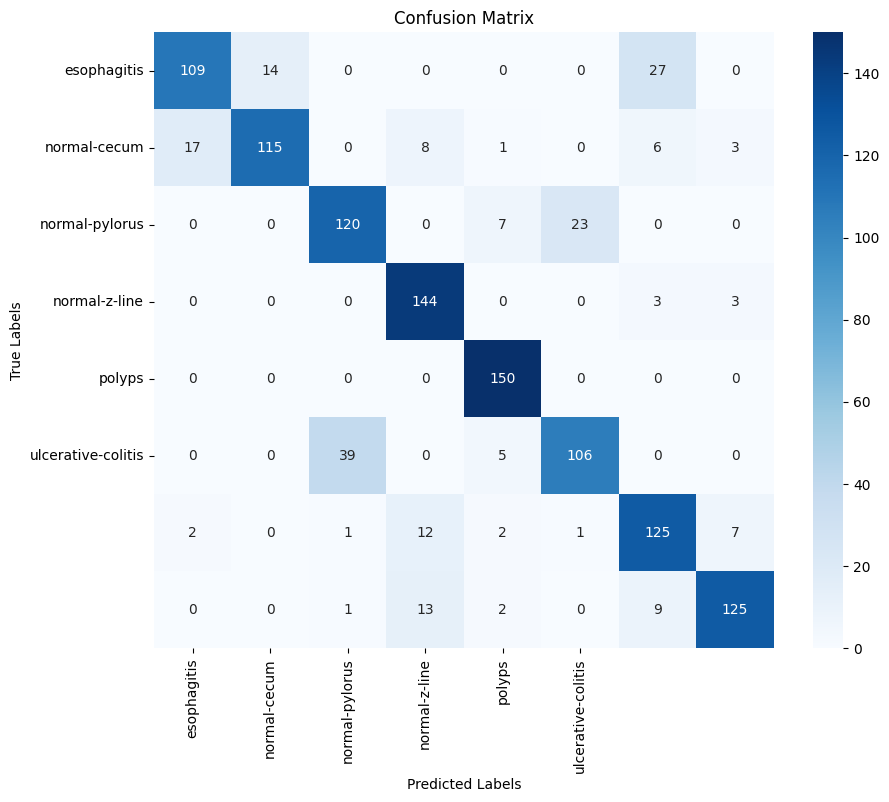

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.85      0.73      0.78       150
dyed-resection-margins       0.89      0.77      0.82       150
           esophagitis       0.75      0.80      0.77       150
          normal-cecum       0.81      0.96      0.88       150
        normal-pylorus       0.90      1.00      0.95       150
         normal-z-line       0.82      0.71      0.76       150
                polyps       0.74      0.83      0.78       150
    ulcerative-colitis       0.91      0.83      0.87       150

              accuracy                           0.83      1200
             macro avg       0.83      0.83      0.83      1200
          weighted avg       0.83      0.83      0.83      1200



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


test_generator.reset()


true_labels = []
predicted_probs = []


for i in range(len(validation_generator)):
    imgs, labels = next(validation_generator)
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_probs.extend(np.argmax(model.predict(imgs), axis=1))


cm = confusion_matrix(true_labels, predicted_probs)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(true_labels, predicted_probs, target_names=list(validation_generator.class_indices.keys())))

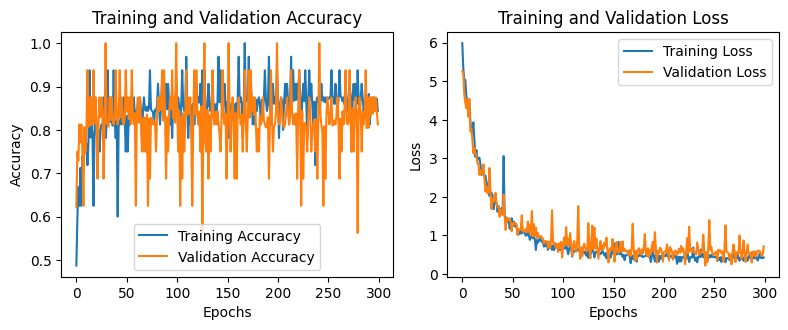

Final Epoch Metrics:
Final Training Accuracy: 0.8438
Final Validation Accuracy: 0.8125
Final Training Loss: 0.4263
Final Validation Loss: 0.7158


In [28]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

if 'precision' in history.history and 'val_precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()


if 'recall' in history.history and 'val_recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()


plt.tight_layout()
plt.show()


print("Final Epoch Metrics:")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

if 'precision' in history.history:
    print(f"Final Training Precision: {history.history['precision'][-1]:.4f}")
    print(f"Final Validation Precision: {history.history['val_precision'][-1]:.4f}")

if 'recall' in history.history:
    print(f"Final Training Recall: {history.history['recall'][-1]:.4f}")
    print(f"Final Validation Recall: {history.history['val_recall'][-1]:.4f}")

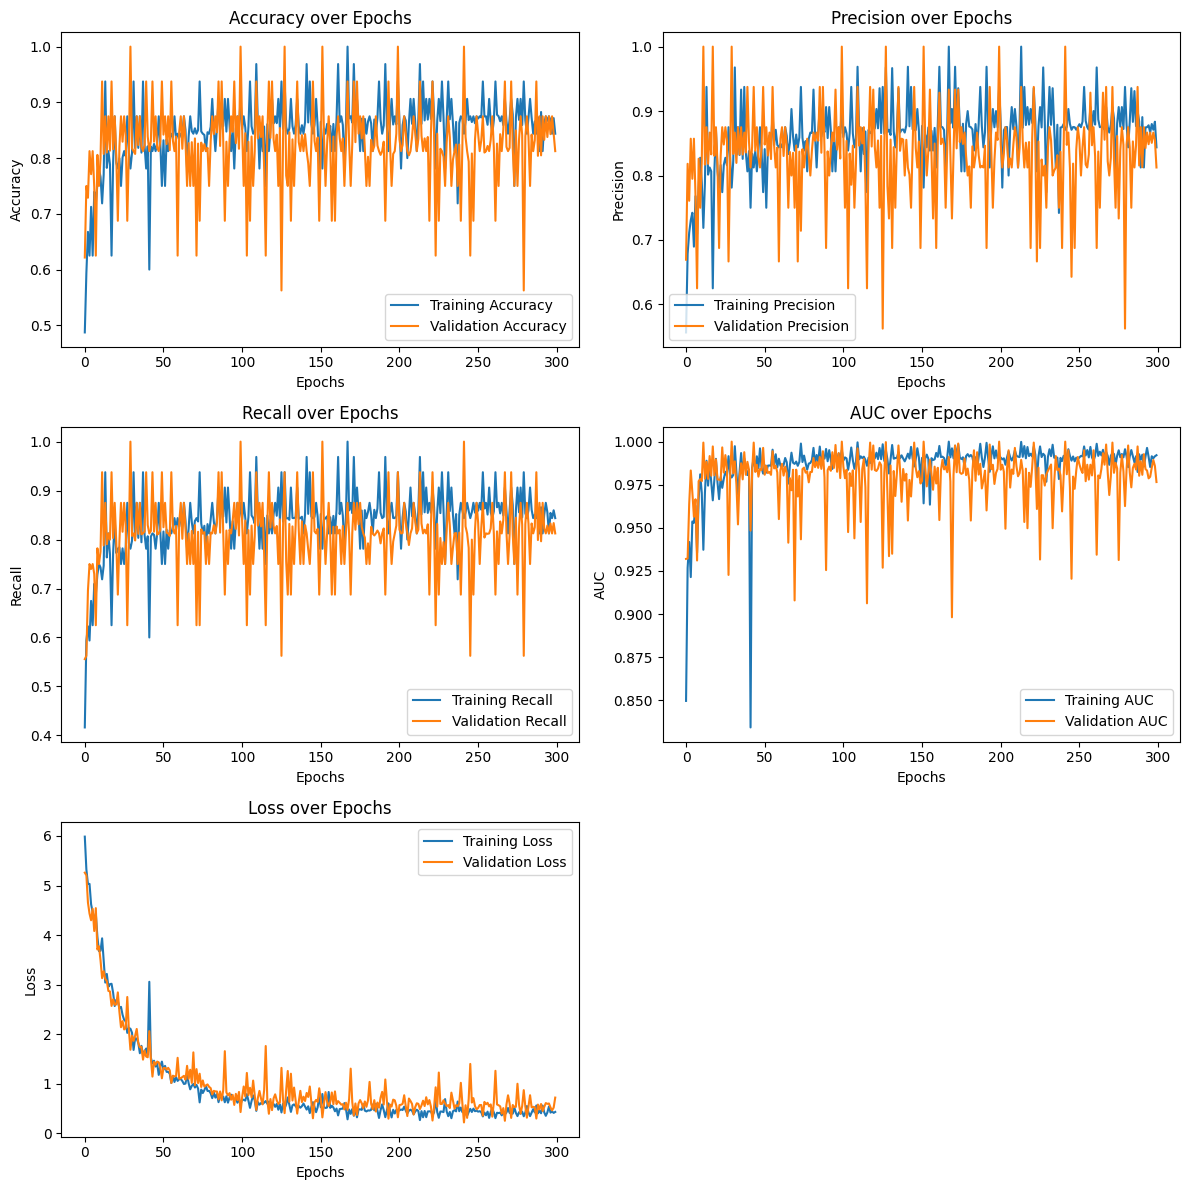

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))

# Accuracy plot
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Precision plot
plt.subplot(3, 2, 2)
plt.plot(history.history['Precision'], label='Training Precision')
plt.plot(history.history['val_Precision'], label='Validation Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall plot
plt.subplot(3, 2, 3)
plt.plot(history.history['Recall'], label='Training Recall')
plt.plot(history.history['val_Recall'], label='Validation Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# AUC plot
plt.subplot(3, 2, 4)
plt.plot(history.history['AUC'], label='Training AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# Loss plot
plt.subplot(3, 2, 5)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


if 'lr' in history.history:
    plt.subplot(3, 2, 6)
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()


plt.tight_layout()
plt.show()